In [5]:
##### Read the zip files as an xarray dataset
import os
import scipy.ndimage as ndi
import numpy as np
from numpy import *
import xarray as xr
import glob
import datetime
import zipfile
from osgeo import gdal
from rasterio import features
import fiona
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import warnings

warnings.filterwarnings("ignore")
#%load_ext lab_black

config = {
    "prep_file_dir": "/Users/mohsen/Desktop/EveryField/Test_Dataset/Iran",
    "prep_tile_id": "STA",
    "prep_base_chunk": "auto",
    "prep_time_chunk": "auto",
    "prep_remove_overlap": True,
    "prep_x_start": 0,
    "prep_y_start": 0,
    "prep_step": 1000,
    "prep_clip_percentile": 1,
    "shp_out_dir": "/Users/mohsen/Desktop/EveryField/Test_Dataset/ir_out/",
    "shp_file_out_str": "_MASK_Class_3_",
}


def clip_nan(array, percentile):
    """
    clip values above and below a certain percentile of the array
    """
    np.seterr(divide="ignore", invalid="ignore")
    vmax = np.nanpercentile(array, 100 - percentile)
    vmin = np.nanpercentile(array, percentile)
    array_clip = np.clip((array), a_min=vmin, a_max=vmax)
    return array_clip


def normalize(array):
    """
    normalized numpy array into scale 0.0 - 1.0
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))


def xr_get_zip_info_to_dict(zip_file):
    """
    Expects a list of zipped sentinel tiles and
    an epsg code (which needs to be consistent for all tiles)
    in the format: "EPSG_32614", which can be identified from calling !gdalinfo
    Returns a dictionary consisisting tile information (metadata)
    """

    ### Info from file name
    file_name = zip_file[:-4]
    tile_id = zip_file[-26:-20]
    date_str = zip_file[-19:-11]
    date_obj = datetime.datetime.strptime(date_str, "%Y%m%d")
    platform = zip_file[:3]
    prod_level = zip_file[7:10]

    gdal_info = gdal.Info(zip_file, format="json")

    # set GDAL call for 10m bands in zip tile directory
    gdal_str = gdal_info["metadata"]["SUBDATASETS"]["SUBDATASET_1_NAME"]
    epsg = gdal_str[-10:]
    cloud_coverage = float(gdal_info["metadata"][""]["CLOUD_COVERAGE_ASSESSMENT"])
    nodata_pixel_percentage = float(
        gdal_info["metadata"][""]["NODATA_PIXEL_PERCENTAGE"]
    )

    # Get string for cloud mask image
    # Get contents of zip file as a list
    zip_contents = zipfile.ZipFile(zip_file, "r")
    # path to 20m cloud mask within the zipped file
    cld_path = [s for s in zip_contents.namelist() if "MSK_CLDPRB_20m.jp2" in s]
    # create string to call cloud mask .jp2 from zipped file with rasterio
    cld_mask_str = "/vsizip/" + zip_file + "/" + cld_path[0]

    # return dict of tile info with top level key: file name
    info_dict = {
        file_name: {
            "tile_id": tile_id,
            "date_str": date_str,
            "date_obj": date_obj,
            "gdal_str": gdal_str,
            "epsg": epsg,
            "cloud_coverage": cloud_coverage,
            "nodata_pixel_percentage": nodata_pixel_percentage,
            "platform": platform,
            "product_level": prod_level,
            "cloud_mask_str": cld_mask_str,
        }
    }

    return info_dict


def xr_dict_to_dataset_cloud_mask(
    da_name,
    gdal_str,
    date_obj,
    tile_id,
    chunks=(-1, config["prep_step"], config["prep_step"]),
    remove_overlap=config["prep_remove_overlap"],
    x_start=config["prep_x_start"],
    y_start=config["prep_x_start"],
    step=config["prep_step"],
):


    # Lazily read file to xarray DataArray
    rio_da = xr.open_rasterio(gdal_str, chunks=chunks)
    # set time coordinate
    rio_da["time"] = date_obj
    # set da name
    rio_da.name = da_name
    # set tile_id
    rio_da.attrs["tile_id"] = tile_id

    # this removes the area overlapping with the neighboring tile on the right and bottom
    # The overlap is 983 pixels, but using 980 results in a clean 10000 by 10000 pixel tile
    if remove_overlap:
        rio_da = rio_da[:, :-980, :-980]
   
    x = x_start
    y = y_start
    x_end = x + step
    y_end = y + step
    rio_da = rio_da[:, x:x_end, y:y_end]

    # convert to dataset
    ds = rio_da.to_dataset(dim="band")
    ds = ds.rename_vars({1: "red", 2: "green", 3: "blue", 4: "nir"})

    return ds


def prep_data():
    """
        This function gets parameters like 'tile_id' and 'prep_data_dir' and others to access the zipped sentinel 2 files downloaded from https://scihub.copernicus.eu/dhus/#/home
        prep_data applies preprocessing steps to the raw data and returns a xarray dataset holding all xarray data arrays that have passed the cloud coverage condition named ds_time_stack.

    """
    
    
    # set variables from global config
    global config
    # file dir
    file_dir = config["prep_file_dir"]
    tile_id = config["prep_tile_id"]
    # chunking
    base_chunk = config["prep_base_chunk"]  # auto
    time_chunk = config["prep_time_chunk"]  # auto
    chunk_size = (time_chunk, base_chunk, base_chunk)
    rechunk_size = {"time": time_chunk, "x": base_chunk, "y": base_chunk}
    # data read parameters
    overlap_bool = config["prep_remove_overlap"]
    x_start = config["prep_x_start"]
    y_start = config["prep_y_start"]
    step = config["prep_step"]
    percentile = config["prep_clip_percentile"]

    # set working directory to the folder with the sentinel data tiles
    # Set file_dir in the global variables at top of the code
    os.chdir(file_dir)

    # the tile_id for the specific study area is "JKH"
    glob_str = "*" + tile_id + "*.zip"
    zip_list = glob.glob(glob_str)

    # build dictionary of metadata from gdal_info calls for each tile in the list of zip_files
    tile_info_dict = {}

    for zip_str in zip_list:
        tile_info_dict.update(xr_get_zip_info_to_dict(zip_str))

    # date list to hold date objects of time slices in the data stack in order to avoid duplicate dates
    date_list = []
    count_total_files = 0

    for k, v in tile_info_dict.items():

        # Print tile info
        print(
            "Image:",
            v["date_str"][:4],
            v["date_str"][4:6],
            v["date_str"][6:],
            "with",
            v["cloud_coverage"],
            "pct | nodata pixel pct:",
            v["nodata_pixel_percentage"],
        )
#         if this is the first tile to pass the cloud coverage thresh, define it as ds_time_stack
        if date_list == []:
            global ds_time_stack
            ds_time_stack = xr_dict_to_dataset_cloud_mask(
                k,
                v["gdal_str"],
                v["date_obj"],
                v["tile_id"],
                chunks=chunk_size,
                remove_overlap=overlap_bool,
                x_start=x_start,
                y_start=y_start,
                step=step,
            )

            date_list.append(v["date_obj"])

        ds_time_stack = xr.concat(
            [
                ds_time_stack,
                xr_dict_to_dataset_cloud_mask(
                    k,
                    v["gdal_str"],
                    v["date_obj"],
                    v["tile_id"],
                    chunks=chunk_size,
                    remove_overlap=overlap_bool,
                    x_start=x_start,
                    y_start=y_start,
                    step=step,
                ),
            ],
            dim="time",
        )
        date_list.append(v["date_obj"])

    # Rechunk the full dataset and sort by time dimension
    ds_time_stack = ds_time_stack.chunk(chunks=rechunk_size).sortby("time")

    # Clip each band in each of the time steps to remove outliers
    # Clip outlier values in each band
    ds_time_stack = ds_time_stack.map(clip_nan, percentile=percentile, keep_attrs=True)

    # Normalize each band
    ds_time_stack = xr.Dataset.chunk(
        ds_time_stack.map(normalize, keep_attrs=True), chunks=rechunk_size
    )

    print("ds_time_stack", ds_time_stack)
    return ds_time_stack




    ## Data read parameters
config["prep_step"] = 1000
print("step----------------> ", config["prep_step"])

### start from top left corner of the image
config["prep_x_start"] = 1000 
config["prep_y_start"] = 2000 #Ben has hand digitized the range of (1000, 1000) to (1000, 6000)

# y_axis = [1000, 2000, 3000, 4000, 5000, 6000]
# x = 1000
# for y in y_axis:
#     main()

ds_time_stack = prep_data()


ds_time_stack



step---------------->  1000
Image: 2020 03 11 with 21.129048 pct | nodata pixel pct: 0.0
Image: 2020 08 18 with 0.785379 pct | nodata pixel pct: 0.0
Image: 2020 05 15 with 0.45283499999999993 pct | nodata pixel pct: 1.3e-05
Image: 2020 11 06 with 27.514565999999995 pct | nodata pixel pct: 0.0
Image: 2020 09 17 with 2.708525 pct | nodata pixel pct: 0.0
Image: 2020 06 19 with 0.071486 pct | nodata pixel pct: 7e-06
Image: 2020 07 19 with 0.334896 pct | nodata pixel pct: 0.0
Image: 2020 04 15 with 1.880352 pct | nodata pixel pct: 7e-06
Image: 2020 10 22 with 0.024506 pct | nodata pixel pct: 3e-06
ds_time_stack <xarray.Dataset>
Dimensions:  (time: 10, x: 1000, y: 1000)
Coordinates:
  * y        (y) float64 4.09e+06 4.09e+06 4.09e+06 ... 4.08e+06 4.08e+06
  * x        (x) float64 2.2e+05 2.2e+05 2.2e+05 ... 2.3e+05 2.3e+05 2.3e+05
  * time     (time) datetime64[ns] 2020-03-11 2020-03-11 ... 2020-11-06
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(10, 1000, 1000), me

<xarray.Dataset>
Dimensions:  (time: 10, x: 1000, y: 1000)
Coordinates:
  * y        (y) float64 4.09e+06 4.09e+06 4.09e+06 ... 4.08e+06 4.08e+06
  * x        (x) float64 2.2e+05 2.2e+05 2.2e+05 ... 2.3e+05 2.3e+05 2.3e+05
  * time     (time) datetime64[ns] 2020-03-11 2020-03-11 ... 2020-11-06
Data variables:
    red      (time, y, x) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    green    (time, y, x) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    blue     (time, y, x) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
    nir      (time, y, x) float64 dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
Attributes:
    transform:     (10.0, 0.0, 199980.0, 0.0, -10.0, 4100040.0)
    crs:           +init=epsg:32639
    res:           (10.0, 10.0)
    is_tiled:      1
    nodatavals:    (nan, nan, nan, nan)
    scales:        (1.0, 1.0, 1.0, 1.0)
    offsets:       (0.0, 0.0, 0.0, 0.0)
    descriptions:  ('B4, central wavelength 665 nm', 'B3, central wavelength ...
    tile_id:       T39STA

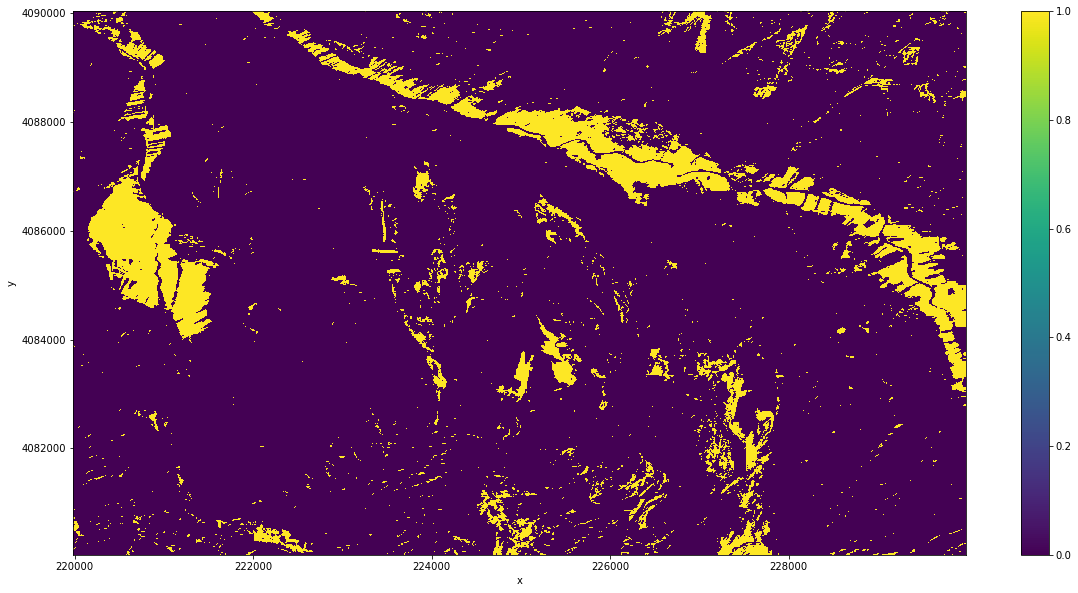

In [6]:
### Masking


def ndvi_xr(input_ds):
    """
    computes the Normalized Difference Vegetation Index (NDVI)
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (input_ds.nir - input_ds.red) / (input_ds.nir + input_ds.red)


def ndwi_xr(input_ds):
    """
    computes the Normalized Difference Water Index (NDWI)
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (input_ds.green - input_ds.nir) / (input_ds.green + input_ds.nir)

def normalize2(array, a, b):
    """
    normalized numpy array into scale [a,b]
    """
    np.seterr(divide="ignore", invalid="ignore")
    return (b-a)*((array - np.nanmin(array)) / (np.nanmax(array) - np.nanmin(array))) + a

ndvi = ndvi_xr(ds_time_stack)
ndwi = ndwi_xr(ds_time_stack)

# Calculate std and var of NDVI over time as new dataArrays
ndvi_std = ndvi.std(dim="time", skipna = False).fillna(0)

ndvi_summer_mean = ndvi.isel(time=[1,2,3,4,5]).mean(dim= 'time', skipna = False)

ndvi_winter_mean = ndvi.isel(time=[0,6,7]).mean(dim= 'time' , skipna = False)

# xr.DataArray(ndvi_summer_mean).plot(figsize=(20, 10))
# xr.DataArray(ndvi_winter_mean).plot(figsize=(20, 10))
normalized_sum = normalize2(ndvi_summer_mean, -1, 1)


normalized_sum_filtered = xr.where(normalized_sum.values<-0.15, -1, normalized_sum.values)

# xr.DataArray(normalized_sum_filtered).plot(figsize=(20, 10))

re_norm = normalize2(normalized_sum_filtered, -1, 1)

# xr.DataArray(re_norm).plot(figsize=(20, 10))

ndvi_summation = xr.where(re_norm<-0.5, -1, re_norm)

# xr.DataArray(ndvi_summation).plot(figsize=(20, 10))

norm_ndvi_std = normalize2(ndvi_std, 0, 1)

# class_bins = [0.2, 0.4, 0.6, 0.8]
class_bins = [0.2, 0.4, 0.5]

# #0-0.2 -> 0
# #0.8-1->4

# #-np.inf

reclass_ndvi_std = xr.apply_ufunc(np.digitize, norm_ndvi_std, class_bins, dask = 'allowed')
# # f, ax = plt.subplots(figsize=(20, 10))

# # im = reclass_ndvi.plot.imshow()
# # ax.set_axis_off()

# # 0.2 < x < 0.4
# mask1_std = xr.where(reclass_ndvi_std==1, 1, 0)
# # mask1.plot(figsize=(20, 10))

# #  x < 0.2
# mask0_std = xr.where(reclass_ndvi_std==0, 1, 0)
# # mask0.plot(figsize=(20, 10))


mean_ndwi = ndwi.isel(time = [0,1,2,3,4,5,6,7]).mean(dim='time', skipna = False)
water_removed = xr.where(mean_ndwi.values > 0.4, -1, ndvi_summation)
# xr.DataArray(water_removed).plot(figsize=(20, 10))



normalized_water_removed = normalize2(water_removed, -1, 1)
final_mean_mask = xr.where(normalized_water_removed < 0.1, 0, 1)
# final_mask1_std = xr.where(reclass_ndvi_std==1, 1, final_mean)
# xr.DataArray(final_mean_mask).plot(figsize=(20, 10))





where_are_NaNs = isnan(normalized_water_removed)
normalized_water_removed[where_are_NaNs] = -1

final_mask1_std = xr.where(reclass_ndvi_std==1, 1, 0)
common = final_mean_mask *final_mask1_std
std_mean_mask = common + final_mean_mask
std_mean_mask = xr.where(std_mean_mask>0, 1, 0)

class_labels = std_mean_mask 
xr.DataArray(class_labels).plot(figsize=(20, 10))






In [8]:
# We can have the mask converted to a pandas dataframe
class_labels.to_pandas()

x,219985.0,219995.0,220005.0,220015.0,220025.0,220035.0,220045.0,220055.0,220065.0,220075.0,...,229885.0,229895.0,229905.0,229915.0,229925.0,229935.0,229945.0,229955.0,229965.0,229975.0
y,,,,,,,,,,,,,,,,,,,,,
4090035.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4090025.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4090015.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4090005.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4089995.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080085.0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4080075.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4080065.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
